<center><h1>Training the final model and making predictions on the testing dataset</h1></center>

[Evaluating model performance on the training data](#evaluation)<br>
[Making predictions on the testing data](#testing)<br>
[Saving the model to file](#saving)

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import os

In [165]:
train_metadata_df = pd.read_csv("challengeA_data/2022challengeA_train_modified.csv", index_col=[0])
train_df = pd.read_csv("challengeA_data/ext_features.csv", index_col=[0]).sample(frac=1).reset_index(drop=True)

test_metadata_df = pd.read_csv("challengeA_data/2022challengeA_test.csv", index_col=[0])
test_metadata_df.head(3)

,file_id,origin,predicted_emotion
0,030472df-9d70-4d76-a1a5-acb4c33537d3.wav,crema,NaN
1,ac4720de-e0d9-4667-86a7-4236d410ed25.wav,crema,NaN
2,264928af-cb15-4125-abf7-9408369d83b2.wav,crema,NaN


In [166]:
test_df = pd.read_csv("challengeA_data/test_ext_features.csv",index_col=[0])
test_df.head(3)

,file_id,rms_max,rms_std,rms_mean,magnitude_max,magnitude_std,magnitude_mean,zero_crossing_rate,contrast_6,contrast_5,...,mfcc_mean_0,flatness,cent_max,cent_std,cent_mean,f0_mean,pitch_min,pitch_max,pitch_std,pitch_mean
0,75e70b60-343d-409f-a956-bf900f0539e8.wav,0.030247,0.005467,0.006978,7.646789,0.192080,0.059084,0.095326,14.980575,15.734339,...,-369.99530,0.030664,0.033477,0.006532,0.010870,144.252273,0.0,170.72797,68.68915,41.313015
1,823ca09a-648d-46ee-bfd7-069a35baeb92.wav,0.250561,0.043656,0.029509,65.521170,1.167429,0.231272,0.109998,14.094052,17.068421,...,-276.97000,0.033838,0.033964,0.005954,0.014493,240.167107,0.0,202.79593,70.46647,31.061205
2,fc3342c6-5c5d-4e7d-9210-b425dfae9408.wav,0.034399,0.009672,0.009711,9.812358,0.305776,0.051465,0.134193,31.265947,17.917684,...,-438.71124,0.023048,0.050212,0.013555,0.017241,567.144093,0.0,0.00000,0.00000,0.000000


The ordering of the files in the test features dataframe and the test metadata dataframe is jumbled. I'll fix this now.

In [167]:
test_df = test_df.set_index("file_id").reindex(index=test_metadata_df["file_id"]).reset_index()
# all() returns true if all values in an iterable are true
assert all(test_df["file_id"] == test_metadata_df["file_id"]), "file_id columns in the two dataframes don't match."
test_df.head(3)

,file_id,rms_max,rms_std,rms_mean,magnitude_max,magnitude_std,magnitude_mean,zero_crossing_rate,contrast_6,contrast_5,...,mfcc_mean_0,flatness,cent_max,cent_std,cent_mean,f0_mean,pitch_min,pitch_max,pitch_std,pitch_mean
0,030472df-9d70-4d76-a1a5-acb4c33537d3.wav,0.025938,0.004957,0.005864,5.774851,0.166755,0.047644,0.079531,14.160105,15.529927,...,-384.55685,0.017052,0.057371,0.009045,0.015152,179.835919,0.0,234.11780,106.812760,128.78543
1,ac4720de-e0d9-4667-86a7-4236d410ed25.wav,0.038292,0.009531,0.010932,9.244533,0.318983,0.075811,0.064860,13.984580,17.722578,...,-360.34990,0.007742,0.043541,0.005398,0.016667,197.844762,0.0,233.87833,104.114710,74.72349
2,264928af-cb15-4125-abf7-9408369d83b2.wav,0.039470,0.006061,0.006540,9.395371,0.195576,0.049954,0.085291,14.074742,15.905888,...,-377.68326,0.017408,0.039598,0.007550,0.015385,167.410335,0.0,171.23587,53.887962,21.27721


The dataframes are now aligned.

In [168]:
scaler = StandardScaler()

# testing data
test_features_df = test_df[test_df.columns[~test_df.columns.isin(["file_id"])]]
test_features = np.array(test_features_df)
scaled_test_features = scaler.fit_transform(test_features)

# training data
train_features_df = train_df[train_df.columns[~train_df.columns.isin(["file_id", "encoded_emotion"])]]
labels = train_df["encoded_emotion"]

train_features = np.array(features_df)
labels = np.array(labels)

scaled_train_features = scaler.fit_transform(train_features)

In [169]:
emotions = sorted(list(train_metadata_df["emotion"].unique()))
num_emotions = len(emotions)

keys = emotions
values = np.arange(7)
emotion_encoder = dict(zip(keys, values))
print(emotion_encoder)
print("\n")
emotion_decoder = dict(zip(list(emotion_encoder.values()), list(emotion_encoder.keys())))
print(emotion_decoder)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}


{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


<a id="evaluation"></a>
<h2>Evaluating the model's performance on the training data</h2>

I borrow helper functions from my other notebooks for evaluation.

In [68]:
def get_confusion_matrix(truth, predictions):
    """Returns the confusion matrix given predictions made by a model and the corresponding truth values.
        predictions: array of integers
        truth: array of integers
    """
    cm = confusion_matrix(truth, predictions)
    return cm

def get_accuracy_by_class(cm, labels):
    """Returns a dictionary with the labels as keys and the accuracy of predictions made by a model as values.
        confusion_matrix: 2D confusion matrix
        labels: list of class names – in this case, emotions
    """
    accuracy_by_class = cm.numpy().diagonal() / cm.sum(axis=1)
    accuracy_by_class = [round(acc, 2) for acc in accuracy_by_class]
    class_accuracy_dict = dict(zip(emotions, accuracy_by_class))
    return class_accuracy_dict
    
def show_confusion_matrix(cm):
    """Takes in predictions and the truth as arrays of scalars to create a confusion matrix. The
        confusion matrix is then displayed using seaborn. 
        predictions: array of integers
        truth: array of integers
    """
    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(cm, annot=True, fmt="",
                    xticklabels=list(emotion_decoder.values()),
                    yticklabels=list(emotion_decoder.values()))
    plt.xlabel("Predicted", fontsize=10, labelpad=5)
    plt.ylabel("Truth", fontsize=10, labelpad=5)

def plot_performance(model_history):
    """Uses the model history dict obtained from model.fit().history to plot the 
    training loss and validation loss in one plot, and the training and validation accuracies in another plot."""
    metrics = model_history.history
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.xlabel("Epoch", labelpad=10, fontsize=10)
    plt.ylabel("Loss", labelpad=10, fontsize=10)
    plt.plot(model_history.epoch, metrics["loss"], metrics["val_loss"])
    plt.legend(["loss", "val_loss"])

    plt.subplot(1, 2, 2)
    plt.xlabel("Epoch", labelpad=10, fontsize=10)
    plt.ylabel("Accuracy", labelpad=10, fontsize=10)
    plt.plot(model_history.epoch, metrics["accuracy"], metrics["val_accuracy"])
    plt.legend(["accuracy", "val_accuracy"])

def validate(est, X, y, split, fold_index, verbose):
    """Fits an estimator model and evaluates its performance.
        est - Estimator/Model
        X - training data
        y - validation data
        split - tuple of indices, where the first item is the training indices; the second the validation indices.
        verbose - if set to true, print when job is complete.
    """
    x_train, y_train = X[split[0], :], y[split[0]]
    x_val, y_val = X[split[1], :], y[split[1]]
    
    # creating the tensorflow datasets from the numpy arrays.
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_ds = train_ds.shuffle(len(train_ds))
    num_train = len(train_ds)
    num_val = int(0.1*num_train)
    # I hold back some of the training data for validation when fitting the model, which is used for 
    # early stopping.
    val_ds = train_ds.take(num_val)
    train_ds = train_ds.skip(num_val)
    batch_size=64
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.shuffle(len(train_ds)).batch(batch_size).cache().prefetch(AUTOTUNE)
    val_ds = val_ds.shuffle(len(val_ds)).batch(batch_size).cache().prefetch(AUTOTUNE)
    
    # Stops training when the validation loss doesn't improve for 3 conecutive epochs.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
    callbacks = [early_stopping]
    # fitting the model 
    est.fit(train_ds, 
            validation_data=val_ds, 
            epochs=100, 
            callbacks=callbacks,
            verbose=0)
    
    # making predictions
    y_pred = est.predict(x_val)
    y_pred = np.argmax(y_pred, axis=1)
    
    # computing and storing the metrics
    metrics = {}
    metrics["accuracy"] = accuracy_score(y_val, y_pred)
    # f1-scores for each individual class: returns an array
    f1_individual_scores = f1_score(y_val, y_pred, average=None) 
    for i, f1_individual_score in enumerate(f1_individual_scores):
        metrics[f"f1_{emotions[i]}"] = f1_individual_score
    # aggregates the contributions of each class, then computes the f1-score, thus not favouring any one class.
    metrics["f1_micro"] = f1_score(y_val, y_pred, average="micro") 
    # Computes the f1-score for each class, then weights them by how frequently they appeared, returning
    # a single score.
    metrics["f1_weighted"] = f1_score(y_val, y_pred, average="weighted")
    # Computes the f1-score for each class and then gets their average.
    metrics["f1_macro"] = f1_score(y_val, y_pred, average="macro") # same as f1_individual.mean()
    
    if verbose: 
        print(f"Completed job {fold_index}")
    return pd.DataFrame(metrics, index=["fold_"+str(fold_index)])

def cross_validate(est, file_name, X, y, n_splits=10, verbose=True):
    """Cross-validates an estimator for n_splits stratified k-fold cross validation.
        file_name - name of the file storing the initial weights of the model, so that each
                    iteration the model is reinitialized, starting learning from scratch.
        X - features
        y - labels
        n_splits - number of folds in cross-validation.
        verbose - if set to true, prints when each validation job is complete.
    """
    # StratifiedKFOld used to ensure that the mean response value is approximately equal in each fold.
    # In simpler terms, it makes sure that the distribution of labels in each fold is somewhat equal.
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(cv.split(scaled_features, labels))
    
    results = []
    # save initial weights so that for each iteration of cross-validation the model can be reinitialized
    path_root = "./dnn_model_weights"
    file_path = os.path.join(path_root, file_name)
    if not os.path.isdir(path_root):
        os.mkdir(path_root)
    est.save_weights(file_path)
    for fold_index, fold in enumerate(folds):
        # Loading the initial model: essentially refreshing the model.
        est.load_weights(file_path)
        results.append(validate(est, X, y, fold, fold_index, verbose))
        
    return pd.concat(results, axis=0)

In [47]:
model = models.Sequential([
    layers.Input(shape=(241,)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(7, activation="softmax")
])

model.summary()

model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy"
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 256)               61952     
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               65792     
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 256)               65792     
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 7)                

In [48]:
# Stratified K-fold cross validation, model trained for at most 100 epochs.
model_metrics = cross_validate(model, "final_model_init", scaled_train_features, labels, n_splits=10, verbose=True)

Completed job 0
Completed job 1
Completed job 2
Completed job 3
Completed job 4
Completed job 5
Completed job 6
Completed job 7
Completed job 8
Completed job 9


In [49]:
model_metrics.mean()

accuracy       0.657864
f1_angry       0.748318
f1_disgust     0.609943
f1_fear        0.600650
f1_happy       0.609028
f1_neutral     0.641414
f1_sadness     0.652882
f1_surprise    0.870191
f1_micro       0.657864
f1_weighted    0.656445
f1_macro       0.676061
dtype: float64

The above metrics are the results of the model after 10-fold cross-validation. However, it would be helpful to see how the model performs during training by plotting its history. I'll split the data into a training, validation and testing set, fit the model to the training data and validate it using the validation data; then I will test the fitted model on the held out testing set and plot a confusion matrix. 

In [87]:
# 90% training, 10% testing. 
# The training dataset will be further split up into 80% for training and 20% for validation.
x_train, x_test, y_train, y_test = train_test_split(scaled_train_features, labels, test_size=0.2)

num_instances = len(x_train)
num_val = int(0.2*num_instances)
num_train = int(0.8*num_instances)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(len(train_ds))
val_ds = train_ds.take(num_val)
train_ds = train_ds.skip(num_val)

batch_size = 64
train_ds = train_ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [88]:
model = models.Sequential([
    layers.Input(shape=(241,)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(7, activation="softmax")
])

model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy"
)

I won't use early stopping so we can see if, or when, the model overfits.

In [89]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=100,
                    verbose=0)

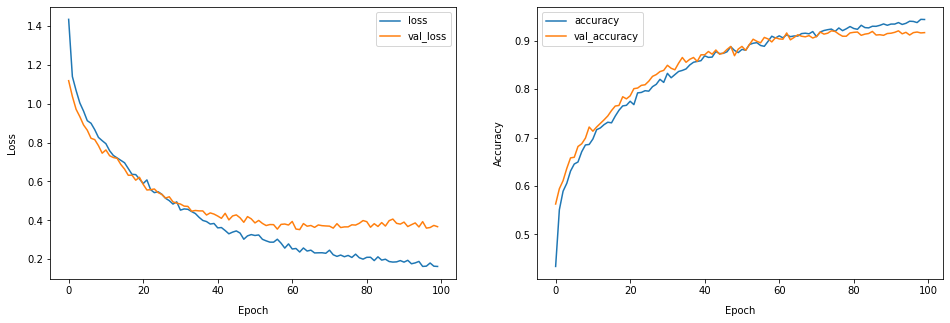

In [90]:
plot_performance(history)

The model strangely performs very well when fitted only once. Though this is deceiving. You'll see this when it makes predictions on the held-out test set.

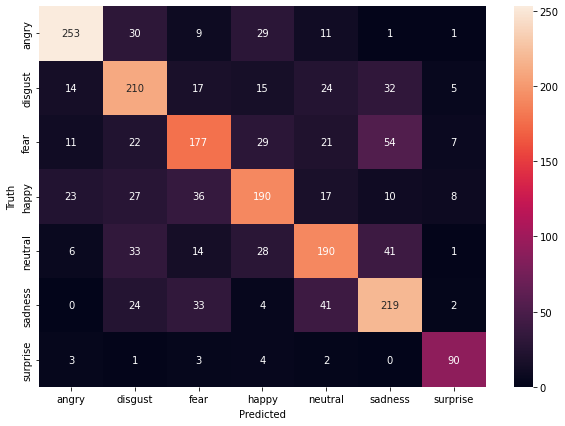

In [91]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
cm = get_confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm)

In [95]:
individual = f1_score(y_test, y_pred, average=None)
macro = f1_score(y_test, y_pred, average="macro")
micro = f1_score(y_test, y_pred, average="micro")
weighted = f1_score(y_test, y_pred, average="weighted")
for index, score in enumerate(individual):
    print(f"f1_{emotions[index]}: {round(score, 2)}")
print('-'*30)
print(f"f1_macro: {round(macro,2)}")
print(f"f1_micro: {round(micro, 2)}")
print(f"f1_weighted: {round(weighted, 2)}")

f1_angry: 0.79
f1_disgust: 0.63
f1_fear: 0.58
f1_happy: 0.62
f1_neutral: 0.61
f1_sadness: 0.64
f1_surprise: 0.83
------------------------------
f1_macro: 0.67
f1_micro: 0.66
f1_weighted: 0.66


And, as can be seen, it achieves very similar metrics to the mean results from 10-fold cross-validation.

<a id="testing"></a>
<h2>Making predictions on the testing data</h2>

I'll fit the model on all the training data to give it as many observations as possible, and then make predictions on the testing data. I'll decode the predictions into the emotions as strings, then insert it as a column into the testing metadata .csv file.

In [170]:
# Building the model
model = models.Sequential([
    layers.Input(shape=(241,)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(7, activation="softmax")
])

model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy"
)

In [171]:
# Creating the datasets
train_ds = tf.data.Dataset.from_tensor_slices((scaled_train_features, labels))
train_ds = train_ds.shuffle(len(train_ds))

num_instances = len(train_ds)
# I'll hold out 15% of teh training data for the validation set which will have its loss 
# monitored for early stopping, to ensure that the model doesn't overfit.
num_val = int(0.15*num_instances)
val_ds = train_ds.take(num_val)
train_ds = train_ds.skip(num_val)

batch_size = 64
train_ds = train_ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [172]:
model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=100,
          callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
          verbose=0)

In [173]:
test_predictions = model.predict(scaled_test_features)
test_predictions = np.argmax(test_predictions, axis=1)
# test predictions are now integer values in the range [0, 7). They can be
# decoded, i.e. the emotion as a word can be extracted, by passing in their value
# as an index into the emotions list.
test_predictions = [emotions[pred] for pred in test_predictions]

Now, I save these predictions to the ```predicted_emotion``` column in the testing metadata dataframe.

In [174]:
test_metadata_df["predicted_emotion"] = test_predictions
test_metadata_df.head()

,file_id,origin,predicted_emotion
0,030472df-9d70-4d76-a1a5-acb4c33537d3.wav,crema,neutral
1,ac4720de-e0d9-4667-86a7-4236d410ed25.wav,crema,neutral
2,264928af-cb15-4125-abf7-9408369d83b2.wav,crema,happy
3,2233ce2b-35ae-483c-9397-1058f681b6ef.wav,crema,fear
4,472aa1eb-b4dc-452c-84b7-934ed61285da.wav,crema,disgust


The predicted emotions are now in the dataframe. I'll save this dataframe as a .csv file, named " "final_test_answers.csv".

In [175]:
test_metadata_df.to_csv("challengeA_data/final_test_answers.csv")

<a id="saving"></a>
<h2>Saving model to file</h2>

I'll also save this final fitted model to file.

In [176]:
model.save("./final_model")

INFO:tensorflow:Assets written to: ./final_model/assets


In [177]:
loaded_model = tf.keras.models.load_model("./final_model")
loaded_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 256)               61952     
                                                                 
 dropout_39 (Dropout)        (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 256)               65792     
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_54 (Dense)            (None, 256)               65792     
                                                                 
 dropout_41 (Dropout)        (None, 256)               0         
                                                                 
 dense_55 (Dense)            (None, 7)               

When loading the model again, you can see that the architecture is the same as was defined earlier. And to prove that it's exactly the same as the model fitted on the training data, I will make predictions with the loaded model on the testing data and check that it make the exact same predictions as it did earlier.

In [178]:
loaded_model_predictions = loaded_model.predict(scaled_test_features)
loaded_model_predictions = np.argmax(loaded_model_predictions, axis=1)
loaded_model_predictions = [emotions[pred] for pred in loaded_model_predictions]

In [179]:
for pred1, pred2 in zip(loaded_model_predictions, test_predictions):
    assert pred1==pred2, "The predictions don't match; the model wasn't saved correctly."
print("The predictions match.")

The predictions match.


And that brings us to the end of this challenge.

The experience I gained from this competition was nothing short of astounding. I greatly appreciate you all giving me the opportunity to compete, and for considering my project.